In [2]:
import fairsearchcore as fsc
from fairsearchcore.models import FairScoreDoc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fairsearchcore import re_ranker


In [3]:
k = 20 # number of topK elements returned (value should be between 10 and 400)
p = 0.25 # proportion of protected candidates in the topK elements (value should be between 0.02 and 0.98) 
alpha = 0.1 # significance level (value should be between 0.01 and 0.15)

# create the Fair object 
fair = fsc.Fair(k, p, alpha)


In [4]:
gen_ranking = [FairScoreDoc(d_id, score, protected)
    for d_id, score, protected in
    zip(range(k), np.random.rand(k), np.random.choice([True, False], k))]

In [5]:
fair.is_fair(gen_ranking)

True

In [6]:
unfair_ranking = [FairScoreDoc(20, 20, False), FairScoreDoc(19, 19, False), FairScoreDoc(18, 18, False),
                      FairScoreDoc(17, 17, False), FairScoreDoc(16, 16, False), FairScoreDoc(15, 15, False),
                      FairScoreDoc(14, 14, False), FairScoreDoc(13, 13, False), FairScoreDoc(12, 12, False),
                      FairScoreDoc(11, 11, False), FairScoreDoc(10, 10, False), FairScoreDoc(9, 9, False),
                      FairScoreDoc(8, 8, False), FairScoreDoc(7, 7, False), FairScoreDoc(6, 6, True),
                      FairScoreDoc(5, 5, True), FairScoreDoc(4, 4, True), FairScoreDoc(3, 3, True),
                      FairScoreDoc(2, 2, True), FairScoreDoc(1, 1, True)]
                      
# let's check the ranking is considered fair
fair.is_fair(unfair_ranking)


False

In [7]:
re_ranked = fair.re_rank(unfair_ranking)
fair.is_fair(re_ranked)

True

In [8]:
re_ranked

[<FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Protected]>]

# Check fairness in the recommendations

In [9]:
k = 10 # number of topK elements returned (value should be between 10 and 400)
# TODO: check if this p is the global p
# 1−0,3602
p = 0.6398 # proportion of protected candidates in the topK elements (value should be between 0.02 and 0.98) 
alpha = 0.1 # significance level (value should be between 0.01 and 0.15)

# create the Fair object 
fair = fsc.Fair(k, p, alpha)

In [10]:
df_for_fair = pd.read_csv("df_for_fair_74681417.csv")
df_for_fair.head()

,u_id,pscore,developed_country
0,100297,2.263848,1.0
1,3874623,2.024328,1.0
2,5923139,1.902712,1.0
3,7574575,1.897878,0.0
4,325565,1.845899,1.0


In [11]:
recom_ranking = [FairScoreDoc(int(u_id), pscore, bool(1-dev_country))
    for _, (u_id, pscore, dev_country) in df_for_fair.iterrows()]

In [12]:
fair.is_fair(recom_ranking)

ValueError: Number of documents in ranking and mtable length must be equal!

In [34]:
re_ranked = fair.re_rank(recom_ranking)

In [35]:
fair.is_fair(re_ranked)

True

In [36]:
re_ranked

[<FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Nonprotected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Protected]>,
 <FairScoreDoc [Nonprotected]>]

In [37]:
1-df_for_fair[:40]["developed_country"].mean()

0.44999999999999996

In [38]:
recom_ranking = [FairScoreDoc(int(u_id), pscore, bool(1-dev_country))
    for _, (u_id, pscore, dev_country) in df_for_fair[:38].iterrows()]

In [39]:
k = 38
p = 0.65
alpha = 0.01

fair2 = fsc.Fair(k, p, alpha)

In [40]:
fair2.is_fair(recom_ranking)

True

In [41]:
re_ranked = fair2.re_rank(recom_ranking)

In [42]:
fair2.is_fair(re_ranked)

True

In [43]:
top_k = list(range(41))

mean_proportion = []
# process pool
for k in top_k:
    mean_proportion.append(df_for_fair.head(k)["developed_country"].mean())

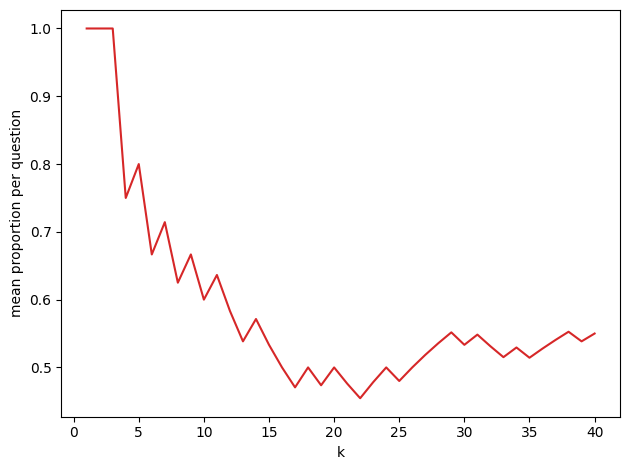

In [44]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('mean proportion per question')
ax1.plot(top_k, mean_proportion, color=color)

fig.tight_layout()
plt.show()

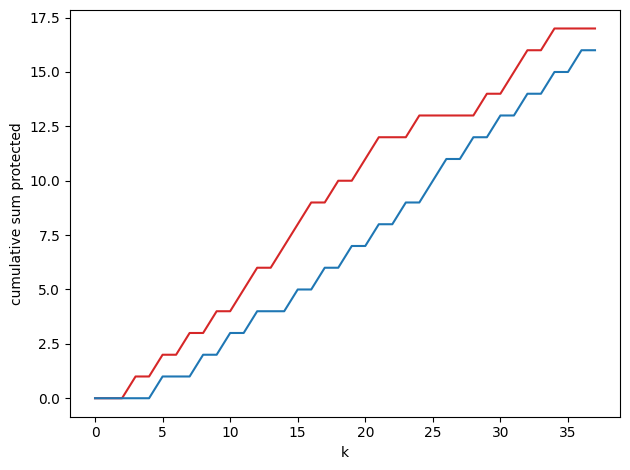

In [45]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('cumulative sum protected')
ax1.plot(range(38), (1-df_for_fair[:38]["developed_country"]).cumsum(), color=color)
ax1.plot(range(38), fair2.create_adjusted_mtable())



fig.tight_layout()
plt.show()

In [47]:
# p = 0.63
# alpha = 0.05

# for k in range(10, 350, 5):
#     recom_ranking = [FairScoreDoc(int(u_id), pscore, bool(1-dev_country))
#         for _, (u_id, pscore, dev_country) in df_for_fair[:k].iterrows()]

#     fair_aux = fsc.Fair(k, p, alpha)
#     base_fair = fair_aux.is_fair(recom_ranking)
#     re_ranked = fair_aux.re_rank(recom_ranking)
#     re_ranked_fair = fair_aux.is_fair(re_ranked)
#     if not base_fair and re_ranked_fair:
#         print(k)

In [48]:
recom_ranking = []
for k in range(10, 12):
    recom_ranking.append([FairScoreDoc(int(u_id), pscore, bool(1-dev_country))
        for _, (u_id, pscore, dev_country) in df_for_fair[:10].iterrows()])

In [49]:
k=30
p = 0.66
alpha = 0.05

recom_ranking = [FairScoreDoc(int(u_id), pscore, bool(1-dev_country))
    for _, (u_id, pscore, dev_country) in df_for_fair[:k].iterrows()]

fair_aux = fsc.Fair(k, p, alpha)
fair_aux.is_fair(recom_ranking)

False

In [50]:
re_ranked = fair_aux.re_rank(recom_ranking)
fair_aux.is_fair(re_ranked)

True

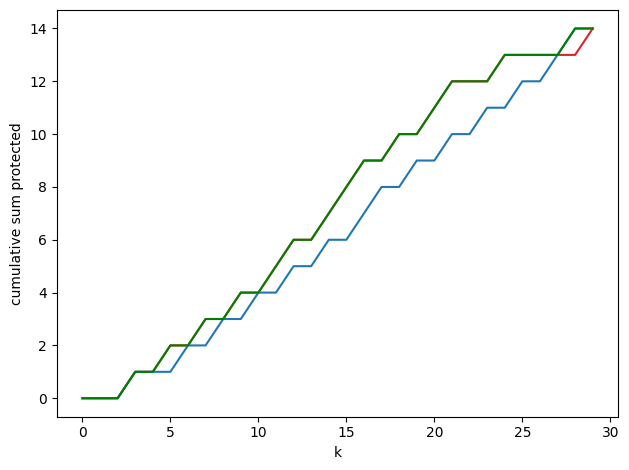

In [51]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('cumulative sum protected')
ax1.plot(range(30), (1-df_for_fair[:30]["developed_country"]).cumsum(), color=color)
ax1.plot(range(30), fair_aux.create_adjusted_mtable())
ax1.plot(range(30), np.cumsum([int(re_r.is_protected) for re_r in re_ranked]), color="green")


fig.tight_layout()
plt.show()

In [52]:
k=100
p = 0.63
alpha = 0.05

recom_ranking = [FairScoreDoc(int(u_id), pscore, bool(1-dev_country))
    for _, (u_id, pscore, dev_country) in df_for_fair[:k].iterrows()]

fair_aux = fsc.Fair(k, p, alpha)
fair_aux.is_fair(recom_ranking)

False

In [53]:
re_ranked = fair_aux.re_rank(recom_ranking)
fair_aux.is_fair(re_ranked)

False

In [54]:

fair_aux.is_fair()

TypeError: is_fair() missing 1 required positional argument: 'ranking'

In [ ]:
len(fair_aux.re_rank([FairScoreDoc(int(u_id), pscore, bool(1-dev_country))
    for _, (u_id, pscore, dev_country) in df_for_fair[:200].iterrows()]))

100

In [ ]:
protected = []
non_protected = []
for _, (u_id, pscore, dev_country) in df_for_fair.iterrows():
    if len(protected)<k and bool(1-dev_country):
        protected.append(FairScoreDoc(int(u_id), pscore, bool(1-dev_country)))
    elif len(non_protected)<k:
        non_protected.append(FairScoreDoc(int(u_id), pscore, bool(1-dev_country)))
    if len(protected) ==k and len(non_protected)==k:
        break

In [62]:
k=100
p = 0.66
alpha = 0.05

recom_ranking = [FairScoreDoc(int(u_id), pscore, bool(1-dev_country))
    for _, (u_id, pscore, dev_country) in df_for_fair.iterrows()]

fair_aux = fsc.Fair(k, p, alpha)

re_ranked = fair_aux.re_rank(recom_ranking)
fair_aux.is_fair(re_ranked)

True

cuantos cambios se hacen para hacer un ranking justo

como cuento los cambios?

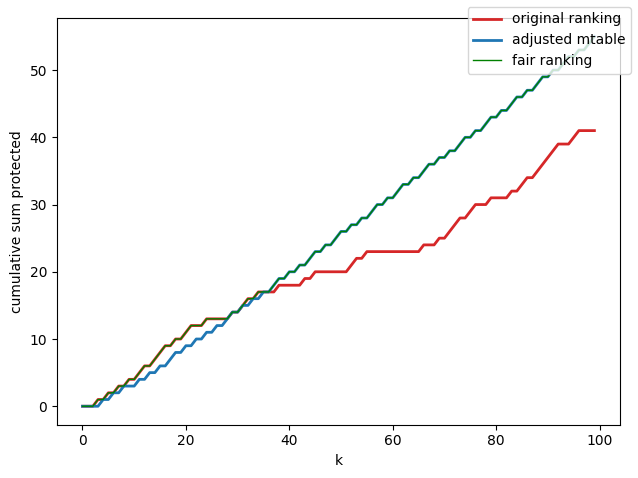

In [63]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('cumulative sum protected')
ax1.plot(range(k), (1-df_for_fair[:k]["developed_country"]).cumsum(), color=color, label="original ranking", linewidth=2)
ax1.plot(range(k), fair_aux.create_adjusted_mtable(), label="adjusted mtable", linewidth=2)
ax1.plot(range(k), np.cumsum([int(re_r.is_protected) for re_r in re_ranked]), color="green", label="fair ranking", linewidth=1)
fig.legend()

fig.tight_layout()
plt.show()